In [1]:
import numpy as np
import matplotlib.pyplot as plt
import EPPE_Simulator as eppe
import astropy.constants as const

In [2]:
systems = eppe.Systems(load=True)
mission = eppe.EPPE()
fp, fstar, noise = mission.observe(systems, 3600)

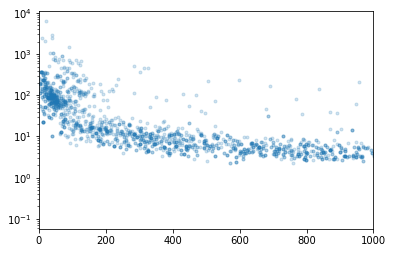

In [3]:
plt.semilogy(systems.catalogue['dist']/const.pc.value, fstar/noise, '.', alpha=0.2)
plt.xlim(0,1000)
plt.show()

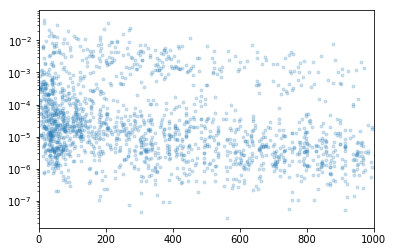

In [4]:
plt.semilogy(systems.catalogue['dist']/const.pc.value, fp/noise, '.', alpha=0.2)
plt.xlim(0,1000)
plt.show()